# Esercitazione 8
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione otto è raccolto nella cartella `Lab_08`. I codici si trovano nelle cartelle `Code/8.1, 8.2, 8.3`, corrispondenti agli esercizi assegnati. I risultati sono invece raccolti nella cartella `Results`, fatta eccezione per alcuni files che ho trovato più comodo lasciare nelle cartelle contenenti i relativi codici.

---

Questo Jupyter Notebook è organizzato nel modo seguente:
- 8.0 caricamento dei pacchetti e introduzione;
- 8.1 costruzione di un codice _Variational Monte Carlo_ (VMC);
- 8.2 ottimizzazione dei parametri per la stima $\langle H \rangle_T$;
- 8.3 studio dello stesso sistema quantistico con metodi PIMC/PIGS.

## 8.0 - caricamento dei pacchetti e introduzione

L'algoritmo di Metropolis può essere utilizzato per stimare i valori d'aspettazione di interesse in sistemi quantistici, in questo caso siamo interessati particolarmente al valore di aspettazione dell'hamiltoniana $\langle \hat{H} \rangle$ al _ground state_ (GS) di una particella quantistica 1D confinata nel potenziale:

$$ V(x)= x^4- \frac{5}{2} x^2.$$

---

In primo luogo assumiamo si conoscere la forma analitica della funzione d'onda, che chiamiamo $\Psi(x|\vec{\beta})$, dove $\vec{\beta}$ è un vettore contenente i parametri della funzione d'onda. In questo caso consideriamo una funzione del tipo:

$$
\Psi_T(x|\sigma, \mu) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$

dove $\mu$ e $\sigma$ sono i due componenti del vettore dei parametri e indico con il pedice $T$ il fatto che il problema viene affrontato ad una temperatura fissata. Il _Variational Principle_ afferma che, scelta una forma analitica per la funzione d'onda dipendente da alcuni parametri variazionali è possibile ottenere un limite superiore alla stima dell'energia media di GS (il cui valore vero è $E_0$) minimizzando la seguente espressione:

$$ E(\vec{\beta})= \frac{\int dx \Psi^*(x|\vec{\beta})\, H\, \Psi(x|\vec{\beta})}{\int dx |\Psi(x|\vec{\beta})|^2} \geq E_0.$$ 



In secondo luogo, sappiamo che tramite $M(RT)^2$ è possibile campionare la regione di spazio di interesse con un certo numero di passi (chiamo $x_i$ la posizione occupata dal _walker_ al passo $i$-esimo) e che tale campionamento, una volta scelto un appropriato nucleo stocastico (regolare, ergodico), tende ad approssimare una fissata distribuzione densità di probabilità. Per rendere utile al problema tale procedura imponiamo che la distribuzione di probabilità che governa il campionamento del Metropolis sia $|\Psi(x|\vec{\beta})|^2$. A questo punto, a ciascun passo dell'algoritmo corrisponde una configurazione del sistema, in cui è possibile calcolare il valore locale dell'energia $E_L(x_i)$. Una volta raccolti tutti i valori, l'energia del sistema può essere stimata nel modo seguente:

$$ E_T = \langle \hat{H} \rangle_T = \frac{1}{N_{step}}\sum_i E_L(x_i), \qquad \text{con}\qquad E_L(x_i)=\frac{\hat{H}\Psi(x_i|\vec{\beta})}{\Psi(x_i|\vec{\beta})} .$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

sns.set_theme(font_scale=1.7, style='whitegrid') 

In [8]:
sample = np.loadtxt("Code/8.1/sampling.dat")
energy = np.loadtxt("Code/8.1/ene.dat")
anneal = np.loadtxt("Results/show_annealing.dat")
par_hi = np.loadtxt("Results/par_history.dat")

In [145]:
taus = [0, 2, 5, 8, 10]
labels = [r'$\tau=0$', r'$\tau=2$',r'$\tau=5$',r'$\tau=8$',r'$\tau=10$']

posi_pigs = []
prob_pigs = []

for i in range(5):
    temporary_ds = np.loadtxt("Code/8.3/probability_"+str(taus[i])+".dat")
    posi_pigs.append(temporary_ds.T[0])
    prob_pigs.append(temporary_ds.T[1])

## 8.1 - Costruzione del codice VMC

__NB:__ nel corso dell'esercitazione ho adottato $\hbar = 1 = m$.

---

In questo primo punto dell'esercitazione costruiamo un codice che ci permetta di effettuare un campionamento (e una stima) fissando il vettore dei parametri nella funzione d'onda. La struttura del codice assomiglia a quella proposta nell'esercizio sei e nel sette. 

La singola mossa di Metropolis, descritta nel metodo `Move` viene proposa a partire da un passo estratto da una distribuzione uniforme $\mathcal{U}[0, \text{stepsize})$ (azione del nucleo stocastico $T$). La probabilità di accettazione di tale mossa viene calcolata come:
$$ \alpha = A(x\to x') = \min \biggl(1, \frac{p(x')}{p(x)} \biggr), $$
con $p(x)$ implementata, come detto in precedenza, come modulo quadro della sovrapposizione di due gaussiane centrate rispettivamente in $\pm \mu$ e di varianza $\sigma^2$. 

Una volta ottenuta la nuova configurazione, viene effettuata la misura. Nel codice ho eseguito tale procedimento eseguendo il calcolo dell'energia variazionale sulla singola configurazione: `walker[ie] = apply_H(x) + eval_V(x)` e utilizzando i numerosi valori ottenuti (le configurazione vengono estratte direttamente nel `blocking`) ho infine eseguito la misura come spiegato in precedenza. Nella stringa che ho riportato compaiono due metodi tramite cui calcolo i contributi all'energia dovuti rispettivamente all'azione dell'hamiltoniana sulla funzione d'onda e del potenziale, entrambi valutati in $x$. Per implementare il metodo `apply_H(x)` ho risolto analiticamente 

$$
\hat{H}|\Psi_T(x)\rangle = \frac{{-\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}.
$$

In questa prima parte dell'esercitazione ho anche effettuato una stima dell'energia del sistema $\langle \hat{H} \rangle_T$ utilizzando il metodo delle medie a blocchi.

---

I risultati riportati nei grafici seguenti sono stati ricavati da una _run_ nella quale ho impostato $\mu=0.81$ e $\sigma=0.62$. Tali valori sono gli stessi estratti dall'analisi svolta nell'esercizio 8.2. Ho eseguito la misura tramite _blocking_ utilizzando $N=100$ blocchi e $L=10^4$ passi per ciascun blocco. Ho messo a confronto la distribuzione campionata dal metropolis con le soluzioni analitica e numerica ottenute utilizzando i parametri $\mu$ e $\sigma$ trovati nel punto due di questa esercitazione.

In [4]:
mu = 0.81
sigma = 0.62

def Vpot(x):
    return (x**2-2.5)*x**2

def Analitic_psi(x,mu,sigma):  #è il modulo quadro della psi di trial normalizzata
    normalization = 2. * sigma * np.sqrt(np.pi) * ( 1. + np.exp(-mu**2/sigma**2) )
    return ((np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))**2)/normalization

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

E,psi = np.linalg.eigh(H)
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

scale = 0.3


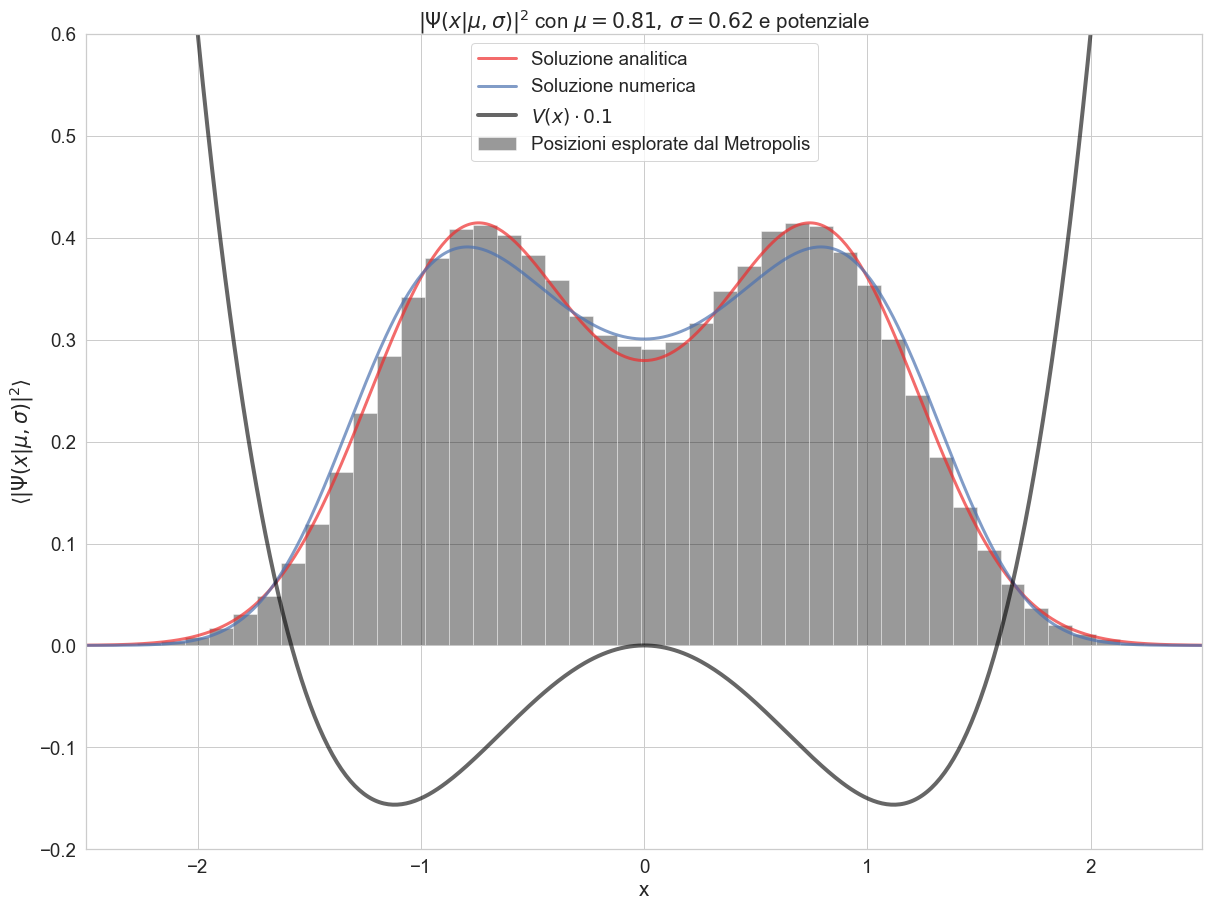

In [12]:
plt.figure(figsize=(20,15))
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.81,\, \sigma=0.62$ e potenziale')
plt.hist(sample, bins=50, density=True, alpha=0.4, color='black', label='Posizioni esplorate dal Metropolis')
plt.plot(x, Analitic_psi(x, mu, sigma), color='#EE2C2C', linewidth=3, alpha=0.7, label='Soluzione analitica')
plt.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=3, alpha=0.7)
plt.plot(x, Vpot(x)*0.1, color='black', linewidth=4, alpha=0.6, linestyle='-', label=r'$V(x)\cdot 0.1$')
plt.ylim(-0.2,0.6)
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel(r'$\langle|\Psi(x|\mu, \sigma)|^2\rangle$')
plt.legend()
plt.show()

__Figura 1:__ istogramma relativo alle posizioni campionate tramite Metropolis. Mettiamo a confronto il risultato dell'algoritmo di VMC con le soluzioni analitica e numerica calcolate con lo script python presentato nella cella precedente ottenute utilizzando gli stessi parametri con i quali ho eseguito il codice VMC. Notiamo che il Metropolis è in grado di campionare molto bene la distribuzione di probabilità che abbiamo deciso di adottare. Notiamo anche che se mettiamo a contronto i risultati ottenuti a partire da questo bias (assunzione di __quella__ funzione d'onda analitica) e la soluzione numerica ci sono delle differenze. Il metropolis è molto efficace nel seguire le indicazioni fornite in partenza, ma la scelta della funzione d'onda deve essere fatta in modo molto preciso, più di come abbiamo fatto in questa sede, se vogliamo ricostruire con precisione il GS vero del sistema in esame.

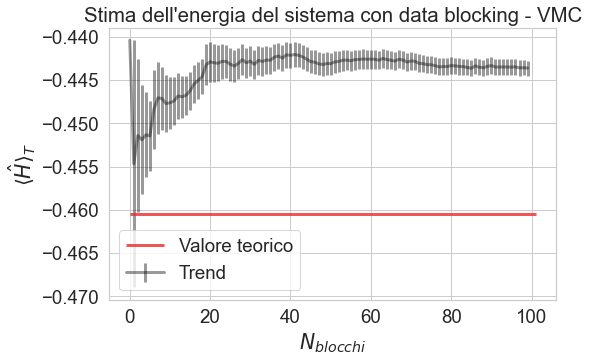

In [14]:
xx = np.arange(100)

plt.figure(figsize=(8,5))
plt.title("Stima dell'energia del sistema con data blocking - VMC")
plt.errorbar(xx, energy.T[2], yerr=energy.T[3], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(-0.46046587969271563,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=3, alpha=0.8)
plt.ylabel(r'$\langle \hat{H} \rangle_T$')
plt.xlabel("$N_{blocchi}$")
plt.legend()
plt.show()

__Figura 2:__ stima del valore di energia totale in funzione del numero di blocchi. Il valore non è compatibile con quello teorico fornito a lezione ma, come ci aspettavamo da un algoritmo che applica il principio variazionale, ci permette di stimare un limite superiore al valore esatto (riporto quello proposto nella consegna: $E_{GS}\simeq -0.46$).

## 8.2 - ottimizzazione dei parametri

Per scegliere in modo intelligente i parametri $\mu, \sigma$ ho implementato un metodo, `simulated_annealing(betai, betaf, Nstep)`, all'interno del quale ho eseguito una ricerca della configurazione del $\vec{\beta}$ ottimale in accordo con l'omonimo algoritmo (SA). In un algoritmo di SA si imposta una temperatura fittizia iniziale (o, analogamente, un $\beta = 1/T$) e si inizia a sottoporre il sistema ad una serie di modifiche con l'intenzione di migliorare una performance (nel nostro caso variamo la configurazione dei due parametri $\mu$ e $\sigma$ con l'intento di trovare delle combinazioni con cui si può ottenere una stima del valor medio dell'hamiltoniana il più basso possibile). L'algoritmo viene eseguito raffreddando sempre di più il sistema e consentendo, perciò, modifiche sempre meno probabili alla configurazione ottenuta fino a quel momento (questo discorso è approfondito nella relazione riguardante l'esercitazione 10). 

In sostanza eseguiamo un campionamento alla Metropolis, in cui ogni nuovo passo viene proposto in accordo con un nucleo stocastico di trasferimento (io ho scelto di generare le nuove posizioni nello spazio dei parametri aggiungendo a $\mu$ e $\sigma$ due incrementi casuali estratti da distribuzioni uniformi tra $-\delta$ e $\delta$, con $\delta=0.025$). Uno studio ancora più accurato potrebbe prevedere l'assunzione di passi casuali differenti per $\mu$ e $\sigma$.

---


Le condizioni iniziali con cui ho avviato la ricerca della soluzione ottimale sono:

$$ \mu=1, \qquad \sigma = 1, $$

che ho scelto osservando la forma del potenziale.

Ho eseguito un totale di `Nstep = 300` passi, tramite cui ho raffreddato il sistema passando da `betai = 1` a `betaf = 300`. In ogni passo dell'algoritmo di SA ho tentato una variazione della coppia di parametri. I valori finali che ho ottenuto per i parametri sono: 

$$ \mu \simeq 0.81, \qquad \sigma \simeq  0.62.$$

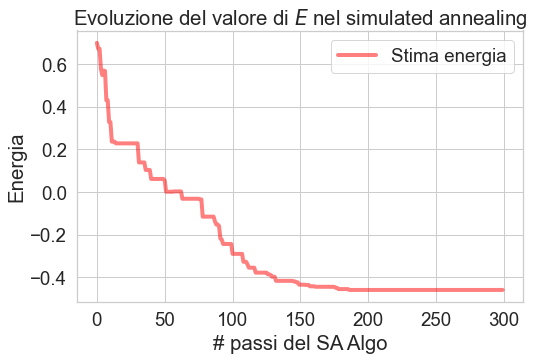

Configurazione ottimale raggiunta: mu, sigma = 0.811425 ,  0.619531


In [128]:
plt.figure(figsize=(8,5))
plt.title('Evoluzione del valore di $E$ nel simulated annealing')
plt.plot(anneal, linewidth=4, alpha=0.5, color='red', label='Stima energia')
plt.legend()
plt.xlabel('# passi del SA Algo')
plt.ylabel('Energia')
plt.show()
#for i in range(len(par_hi)):
#    plt.text(700, 1-i*0.2 , pars[i], bbox=dict(facecolor='red', alpha=0.3))
#    plt.hlines(en_values[i],0,1000, linestyle='--')
print(r'Configurazione ottimale raggiunta: mu, sigma =', 0.811425, ", ", 0.619531)

__Figura 3:__ valore dell'energia totale misurata nel sistema di interesse in funzione del numero di passi dell'algoritmo di Simulated Annealing. Notiamo che inizialmente vengono accettati un gran numero di cambiamenti all'interno dello spazio dei parametri. Dopo una ricerca più frenetica l'algoritmo si assesta sui valori che ho proposto a partire dal passo duecento circa.

## 8.3 - Path Integral Monte Carlo

I metodi di _Path Integral Monte Carlo_ sono pensati per simulare la funzione d'onda di GS di un sistema quantistico. Questo è dovuto al fatto che l'evoluzione temporale della funzione d'onda è espressa nel modo seguente: 

$$ |\Psi(\tau)\rangle = e^{-\tau \hat{H}} |\Psi(0)\rangle = \sum_n c_n e^{-\tau E_n}|\Psi_n\rangle,$$

con $|\Psi_n\rangle$ autostati dell'hamiltoniana e $\tau\equiv it/\hbar$ è detto tempo immaginario di propagazione. Facendo le opportune considerazioni, è possibile ricondurre questo sistema alla dinamica che regola i comportamenti delle catene di Markov. Proprio in quest'ottica, la funzione d'onda assume la forma della distribuzione invariante sotto l'azione di un nucleo stocastico che, in questo caso, corrisponde al propagatore dell'evoluzione temporale. Ciò che ci permette di concentrarci sul ground state è che, al tendere di $\tau$ ad infinito, notiamo che l'unico termine della sommatoria che sopravvive è quello proporzionale al GS.

---

Per trattare questo problema nel concreto abbiamo effettuato alcune considerazioni: 

- abbiamo decomposto il propagatore in $M$ contributi grazie alla decomposizione di Trotter;
- abbiamo  considerato $\tau <\infty$;
- abbiamo applicato l'__approssimazione primitiva__ al propagatore, grazie a cui è possibile scomporre il contributo alla matrice di densità $\rho(r,r')$ dovuto al potenziale da quello dovuto alla parte cinetica dell'energia;
- abbiamo sfruttato l'isomorfismo che esiste tra una particella quantistica e un polimero classico .

---

Per far questo, abbiamo utilizzato il codice fornito a lezione, eseguendo una prima serie di simulazioni a temperatura $T=0$ (PIGS _method_) per proiettare sullo stato fondamentale del sistema due diversi tipi di funzione d'onda:
1. una funzione d'onda costante $\Psi_T(x)=1$;
2. la funzione d'onda trovata tramite principio variazionale nei punti (8.1) e (8.2);

Nella seconda parte di questo terzo punto ci proponiamo invece di utilizzare questo stesso codice a temperatura finita (PIMC _method_). Osserveremo allora questo sistema monodimensionale in uno stato a $T>0$. Cercando in quel caso di visualizzare il sistema nel _ground state_ ci accorgeremo di ottenere risultati scorretti, dovuti al fatto che si tratta di una condizione di stato miscela, in cui possiamo osservare il contributo dei primi stati eccitati.

---

possiamo eseguire un campionamento delle configurazioni del polimero tramite il Metropolis (tre diversi algoritmi di metropolis, in realtà), ricavando un campione di realizzazioni utilizzabile per eseguire misure relative al nostro sistema quantistico (energie potenziale, cinetica e totale). 
Per applicare questo codice al nostro sistema dobbiamo innanzi tutto fornire al programma la forma analitica del potenziale in cui si trova la nostra particella: 

$$ V(x) = x^4 - \frac{5}{2}x^2. $$

Abbiamo inserito nel codice questo potenziale e le sue derivate prima e seconda. In secondo luogo, abbiamo aggiunto al programma la lettura di una variabile fornita tramite il file `input.dat`, `wf_type`, il cui valore indica quale funzione d'onda intendiamo proiettare sul GS. Il valore zero corrisponde alla funzione d'onda costante, il valore uno quella trovata negli esercizi (8.1) e (8.2).

---

__Sulle accettazioni:__ come in ogni applicazione dell'algoritmo di Metropolis, è bene cercare di ottenere dei campionamenti in cui il tasso di accettazione medio sia intorno al 50%. In questa esercitazione non è sempre stato possibile raggiungere risultati del genere: il parametro che regola le traslazioni rigide dell'intero polimero è il più semplice da calibrare, nel senso che possiamo permetterci di regolarlo in modo arbitrario. Quando invece si tratta di regolare i parametri che influiscono sulle performance del Metropolis in fase di _Brownian Motion_ e _Brownian Bridge Reconstruction_ dobbiamo stare più attenti. Non possiamo infatti impostare l'esecuzione in modo che vengano distrutti e ricostruiti ponti più lunghi dei polimeri stessi. Per questa ragione, in alcuni casi (e si vedrà perché ho riportato in ognuno dei casi i valori ottenuti per i tassi di accettazione) non è stato possibile raggiungere il tasso di accettazione suggerito dalla regola empirica. Dobbiamo inoltre sottolineare che il Metropolis nel caso dei BM è effettuato campionando soltanto la parte di energia dovuta al potenziale, mentre quella cinetica è estratta (perché nota) in modo esatto, in stile importance samplig. Questo potrebbe comportare il fatto che l'accettazione in tal caso rimanga più alta.


### 8.3.1 - $T=0$ e $\Psi(x)= 1$

In [15]:
path    = 'Code/8.3/'
taus    = [1,2,5,8]
color   = ['orange', 'red', 'purple', 'blue']
markers = ['o', 's', '^', 'P']

pigs_x = []
pigs_p = []
pigs_e = []

names   = []
files   = []

for i in range(len(taus)):
    names.append(r'$\Psi$ costante, $\tau$='+str(taus[i]))
    files.append('wf_const_'+str(taus[i])+'.dat')
    pigs_x.append(np.loadtxt(path+files[i]).T[0])
    pigs_p.append(np.loadtxt(path+files[i]).T[1])
    pigs_e.append(np.loadtxt(path+files[i]).T[2])

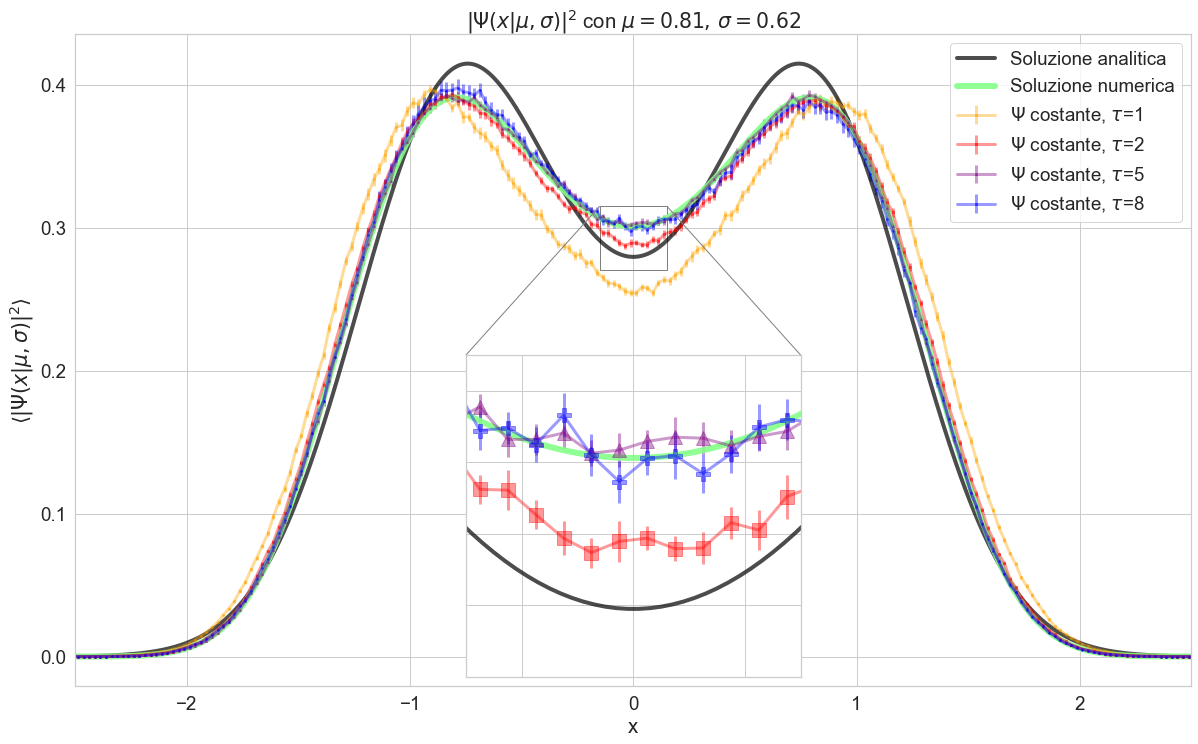

In [16]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.81,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel(r'$\langle|\Psi(x|\mu, \sigma)|^2\rangle$')

axins=zoomed_inset_axes(ax,5,loc=8)   
x1, x2, y1, y2 = -0.15, 0.15, 0.27, 0.315
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
axins.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(len(files)):
    ax.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
    axins.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=14)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')
axins.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')


ax.legend(loc=1)
plt.show()

$$ \tau = 1, \qquad acc_{bm} = 0.72, \qquad acc_{tr} = 0.53, \qquad acc_{bb} = 0.83 $$


---

$$ \tau = 2, \qquad acc_{bm} = 0.68, \qquad acc_{tr} = 0.47, \qquad acc_{bb} = 0.71 $$


---

$$ \tau = 5, \qquad acc_{bm} = 0.51, \qquad acc_{tr} = 0.49, \qquad acc_{bb} = 0.53 $$

---

$$ \tau = 8, \qquad acc_{bm} = 0.49, \qquad acc_{tr} = 0.50, \qquad acc_{bb} = 0.69 $$

__Figura 4:__ in questo primo grafico sono rappresentati i valori stimati della probabilità di trovare la particella quantistica monodimensionale in questione in funzione della posizione. Questi risultati sono stati ottenuti analizzando il sistema a temperatura zero (proiettiamo le funzioni d'onda sul GS). La funzione d'onda che sto proiettando in questo caso è costante. Rispetto alla seconda funzione, che vedremo più avanti, in questo caso risulta molto più difficile ottenere risultati apprezzabili (anche facendo un _tuning_ dei parametri che regolano le accettazioni del Metropolis) nel caso in cui prendiamo in considerazione tempi di propagazione immaginaria piccoli ($\tau<5$). Soltanto superando $\tau=5$, per il quale ho rappresentato i risultati in viola, la curva delle stime puntuali dei valori di densità di probabilità presenta valori compatibili con la soluzione numerica esatta, rappresentata in verde chiaro. Eravamo consapevoli di questo comportamento: è necessario concedere al sistema un tempo immaginario maggiore per far sì che una funzione d'onda la cui forma si discosta da quella vera possa essere proiettata in modo accettabile sul ground state in questione (vedremo infatti che nel caso della funzione ricavata tramite VMC sapremo ottenere risultati compatibili anche per tempi minori).

### 8.3.2 - $T=0$ e $\Psi(x|\mu=0.81, \sigma=0.62)$

In [17]:
path    = 'Code/8.3/'
taus    = [0.1, 1,2,5,8]
color   = ['orange', 'red', 'purple', 'blue', 'green']
markers = ['*','o', 's', '^', 'P', '*']

pigs_x = []
pigs_p = []
pigs_e = []

names   = []
files   = []

for i in range(len(taus)):
    names.append(r'$\Psi$ var, $\tau$='+str(taus[i]))
    files.append('wf_var_'+str(taus[i])+'.dat')
    pigs_x.append(np.loadtxt(path+files[i]).T[0])
    pigs_p.append(np.loadtxt(path+files[i]).T[1])
    pigs_e.append(np.loadtxt(path+files[i]).T[2])

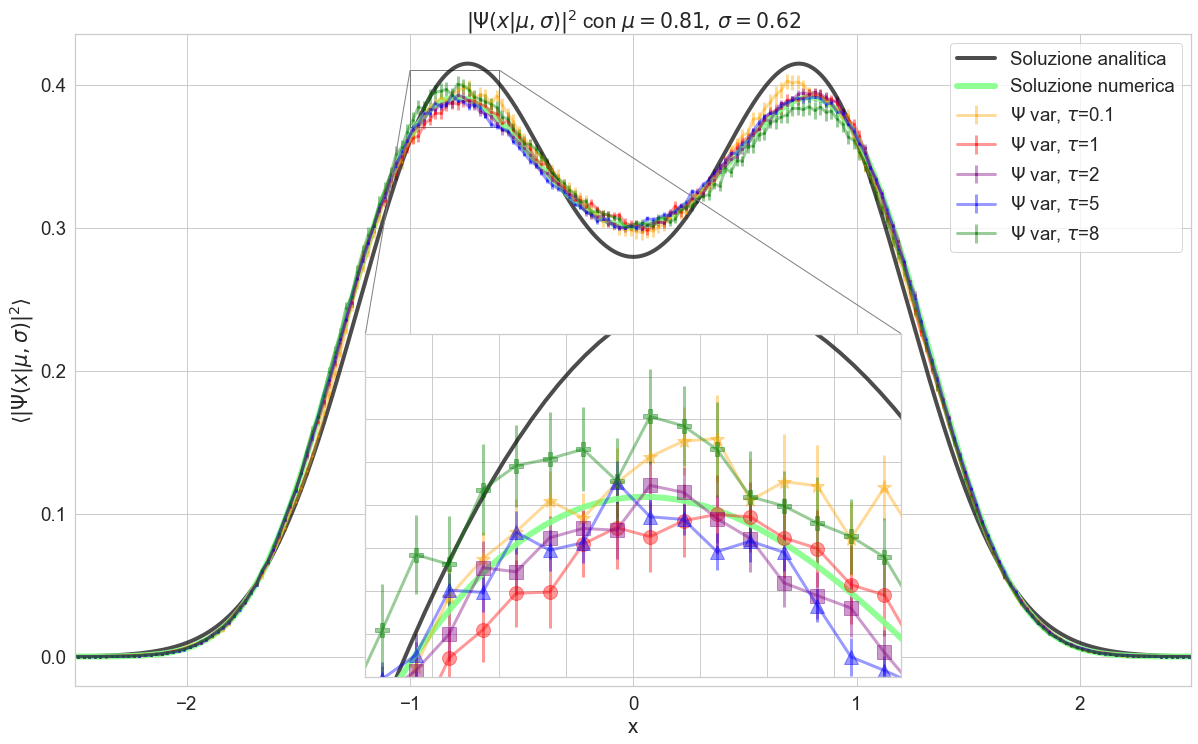

In [18]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.81,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel(r'$\langle|\Psi(x|\mu, \sigma)|^2\rangle$')

axins=zoomed_inset_axes(ax,6,loc=8)   
x1, x2, y1, y2 = -1.0, -0.6, 0.37, 0.41
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
axins.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(len(files)):
    ax.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
    axins.errorbar(pigs_x[i], pigs_p[i], yerr=pigs_e[i], color=color[i], label=names[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=14)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')
axins.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

mark_inset(ax,axins,loc1=1,loc2=2,fc='none',ec='0.5')


ax.legend(loc=1)
plt.show()

$$ \tau = 1, \qquad acc_{bm} = 0.74, \qquad acc_{tr} = 0.51, \qquad acc_{bb} = 0.87 $$


---

$$ \tau = 2, \qquad acc_{bm} = 0.66, \qquad acc_{tr} = 0.52, \qquad acc_{bb} = 0.73 $$

---

$$ \tau = 5, \qquad acc_{bm} = 0.51, \qquad acc_{tr} = 0.48, \qquad acc_{bb} = 0.49 $$

---

$$ \tau = 8, \qquad acc_{bm} = 0.49, \qquad acc_{tr} = 0.50, \qquad acc_{bb} = 0.69 $$


__Figura 5:__ in questo caso stiamo rappresentando la curva rappresentante la densità di probabilità di trovare la particella quantistica in una certa posizione in funzione della posizione proiettando sul GS la funzione d'onda ricavata nei primi due esercizi di questo lavoro. Il primo risultato interessante è che, utilizzando un campionamento più intelligente, siamo in grado di ottenere delle stime compatibili con la soluzione numerica esatta (sempre rappresentata in verde brillante) impostando tempi immaginari molto più piccoli: anche nel caso in cui ho impostato $\tau=0.1$ si ottengono dei risultati apprezzabili, per quanto ancora incompatibili con l'andamento teorico. 

### 8.3.3 - $T>0$ e $\Psi(x|\mu=0.81, \sigma=0.62)$

In [20]:
T = ['0.1', '0.5', '1.25', '5.0']
labels = [r'$T=0.1$', r'$T=0.5$', r'$T=1.25$', r'$T=5$']

pimc_x = []
pimc_p = []
pimc_e = []

for i in range(len(T)):
    pimc_x.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[0])
    pimc_p.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[1])
    pimc_e.append(np.loadtxt("Code/8.3/pimc_T_"+str(T[i])+".dat").T[2])

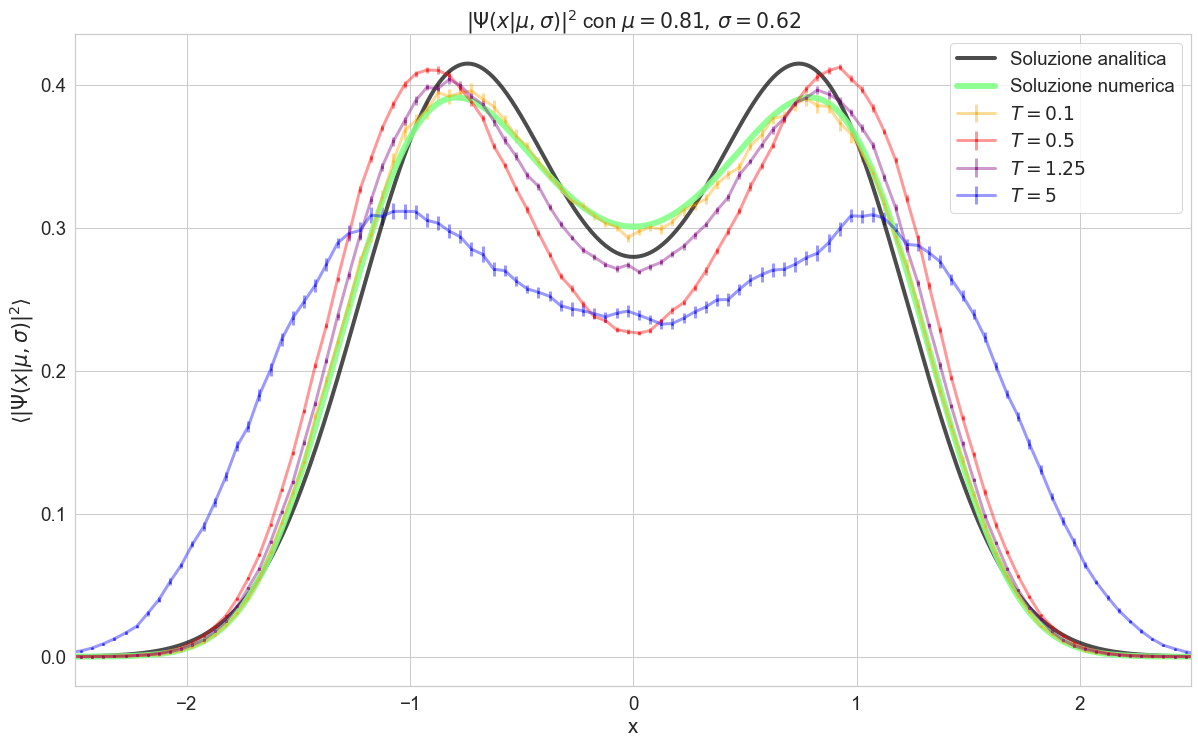

In [21]:
fig, ax = plt.subplots(figsize=[20, 12])
plt.title(r'$|\Psi(x|\mu, \sigma)|^2$ con $\mu=0.81,\, \sigma=0.62$')
plt.xlim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel(r'$\langle|\Psi(x|\mu, \sigma)|^2\rangle$')


#plt.hist(sample, bins=50, density=True, alpha=0.2, color='black', label='Posizioni esplorate dal Metropolis')
ax.plot(x, Analitic_psi(x, mu, sigma), color='black', linewidth=4, alpha=0.7, label='Soluzione analitica')
for i in range(4):
    ax.errorbar(pimc_x[i], pimc_p[i], yerr=pimc_e[i], color=color[i], label=labels[i], linewidth=3, alpha=0.4, marker=markers[i], markersize=2)
ax.plot(x,(psi[0])**2, label = 'Soluzione numerica', linewidth=6, alpha=0.9, color='#84ff88')

ax.legend(loc=1)
plt.show()

$$ T=0.1, \qquad acc_{tr} = 0.52, \qquad acc_{bb}=0.51 $$ 

---

$$ T=0.5, \qquad acc_{tr} = 0.51, \qquad acc_{bb}=0.64 $$ 

---

$$ T=1.25, \qquad acc_{tr} = 0.53, \qquad acc_{bb}=0.91 $$ 

---

$$ T=5.0, \qquad acc_{tr} = 0.48, \qquad acc_{bb}=0.97 $$ 

__Figura 6:__ in questo grafico ho rappresentato il valore stimato delle densità di probabilità puntuali di trovare la particella in una certa posizione in funzione della posizione stessa. Notiamo in modo immediato che, sebbene la mia scelta sia sempre stata quella di proiettare la funzione d'onda trovata negli esercizi precedenti, i risultati che otteniamo sono apprezzabili soltanto per basse temperature (nel caso in cui $T=0.1$). Aumentando la temperatura del sistema, il campionamento delle configurazioni che vengono coinvolte nella misura dell'energia diventa sempre più ampio; il `dtau` è inversamente proporzionale a $T$ e ciò comporta l'accesso a valori dell'energia superiori e, in termini di Metropolis, una maggior probabilità di accettazione delle mosse: iniziamo a coinvolgere configurazioni corrispondenti ai primi stati eccitati del sistema (cosa che possiamo verificare studiando il modo in cui cambia la forma della distribuzione di probabilità, la quale si allontana sempre di più da quella tipica del GS). Questo fenomeno lo notiamo inoltre dall'allargamento della curva all'aumentare di $T$. In modo del tutto naturale, concedendo al sistema l'accesso ad energie maggiori stiamo automaticamente costruendo sistemi sempre più misti, dunque sempre più distanti dal GS. 